In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

sys.path.append("../")
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

Using device: cuda


In [3]:
useNet='CNN2P2'
iterations=10
learningRate=1e-2
verbose=True
doInitWeights=False
pDropout=0

# First, select device to run networks on
if DEVICE is None:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"
print(f"Initiating experiment using {DEVICE}")

# Prepare Network and Preprocessing
batchSize = 1000
weightvars = None # initialize variance of weights with default parameters
convActivation = F.relu
linearActivation = F.relu
net = models.CNN2P2(convActivation=convActivation,linearActivation=linearActivation)

preprocess = transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
])

net.to(DEVICE)

# Prepare Dataloaders
trainloader, testloader, numClasses = nnutils.downloadMNIST(batchSize=batchSize, preprocess=preprocess)

# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
# optimizer = torch.optim.SGD(net.parameters(), lr=learningRate)
optimizer = torch.optim.Adadelta(net.parameters())

# Preallocate summary variables  
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []
alignTest = []
deltaWeights = []

# Store initial network weights to view how things change over training
initWeights = net.getNetworkWeights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,(images,label) in enumerate(trainloader):
        cidx = epoch*len(trainloader) + idx # stores idx of each "miniepoch" 

        # move batch to GPU (if available) 
        images, label = images.to(DEVICE), label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Measure Alignment of weights using current images in batch as a sample

        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # compare eachLook=True with eachLook=False 
        # (meaning measure alignment of convolutional layers for each "look" then average vs. unfolded and measure it once)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        alignFull.append(net.measureAlignment(images))
        alignTest.append(net.measureAlignment(images, eachLook=False))

        # Measure Change in Weights
        deltaWeights.append(net.compareNetworkWeights(initWeights))

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]

    # Print statistics for each epoch
    if verbose: print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))

# Measure performance on test set
totalLoss = 0
numCorrect = 0
numAttempted = 0
for batch in testloader:
    images, label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    outputs = net(images)
    totalLoss += loss_function(outputs,label).item()
    output1 = torch.argmax(outputs,axis=1)
    numCorrect += sum(output1==label)
    numAttempted += images.shape[0]

print(f"Average loss over test set: %.2f." % (totalLoss / len(testloader)))
print(f"Accuracy over test set: %.2f%%." % (100*numCorrect/numAttempted))
print('Training process has finished in %.3f seconds.' % (time.time()-t))

results = {
    'net':net,
    'initWeights':initWeights,
    'alignFull':alignFull,
    'alignTest':alignTest,
    'deltaWeights':deltaWeights,
    'trackLoss':trackLoss,
    'trackAccuracy':trackAccuracy,
    'trainloader':trainloader,
    'testloader':testloader,
    'learningRate':learningRate,
}

Initiating experiment using cuda
Loss in epoch   0: 0.484, Accuracy: 86.30%.
Loss in epoch   1: 0.245, Accuracy: 91.00%.
Loss in epoch   2: 0.184, Accuracy: 94.00%.
Loss in epoch   3: 0.104, Accuracy: 96.90%.
Loss in epoch   4: 0.144, Accuracy: 95.10%.
Loss in epoch   5: 0.093, Accuracy: 97.20%.
Loss in epoch   6: 0.079, Accuracy: 97.60%.
Loss in epoch   7: 0.080, Accuracy: 97.00%.
Loss in epoch   8: 0.062, Accuracy: 97.80%.
Loss in epoch   9: 0.039, Accuracy: 98.50%.
Average loss over test set: 0.07.
Accuracy over test set: 97.74%.
Training process has finished in 135.861 seconds.


In [5]:
# (numLayers, numMiniEpochs) returns average alignment for each layer for each mini-epoch
alignMean = net.avgFromFull(alignFull) 
alignMeanTest = net.avgFromFull(alignTest) # "test" indicates we're testing how alignment is measured when unfolding inputs to network

# [(numNodes, numMiniEpochs) for layer in numLayers] for each layer, return the alignment of each network node for each mini-epoch
alignLayer = [net.layerFromFull(alignFull,layer) for layer in range(net.numLayers)] 
alignLayerTest = [net.layerFromFull(alignTest,layer) for layer in range(net.numLayers)] 

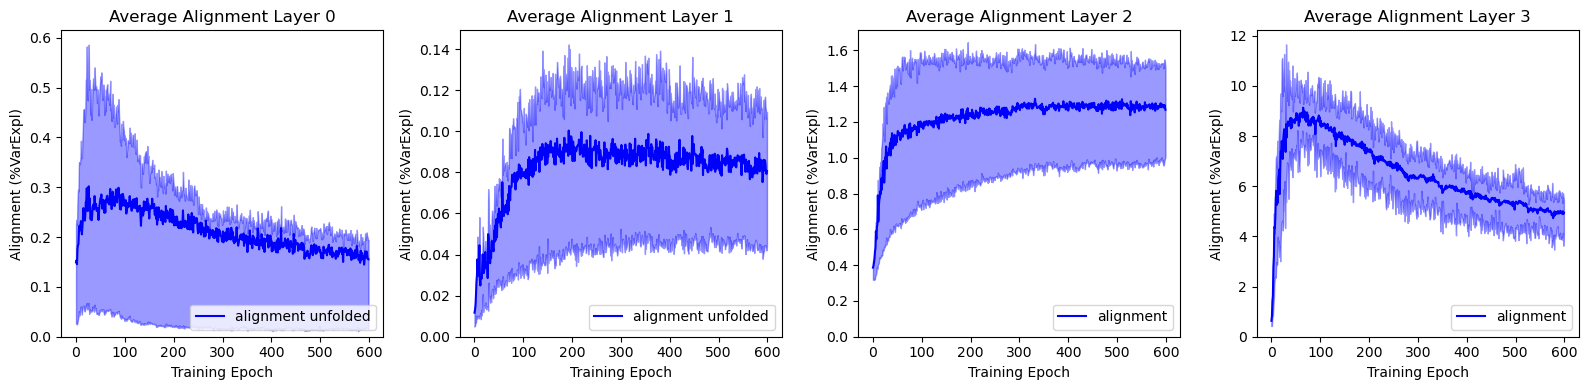

In [16]:
# plot data using unfolded method of alignment or each look method...
totalEpochs = iterations * len(trainloader)

method = 'unfolded' # either 'unfolded' or 'eachLook'

plotData = {
    'unfolded': (alignMeanTest, alignLayerTest, 'b'),
    'eachLook': (alignMean, alignLayer, 'k')
}

qRange = (0.3, 0.7)
fig, ax = plt.subplots(1,net.numLayers, figsize=(16,4))
for layer in range(net.numLayers):
    # get upper and lower quantile of alignment for each layer
    uq = torch.quantile(plotData[method][1][layer],q=qRange[1],dim=0)
    lq = torch.quantile(plotData[method][1][layer],q=qRange[0],dim=0)

    # plot average alignment for each layer (scale to % of variance)
    label = f"alignment {method}" if layer <= 1 else "alignment"
    ax[layer].plot(range(totalEpochs), 100*plotData[method][0][layer], color=plotData[method][2], linewidth=1.5, label=label)
    
    # plot quantile range of alignment for each layer (scale to % of variance)
    ax[layer].fill_between(range(totalEpochs), 100*uq, 100*lq, color=plotData[method][2], alpha=0.4)

    ax[layer].set_ylim(0)
    ax[layer].set_xlabel('Training Epoch')
    ax[layer].set_ylabel('Alignment (%VarExpl)')
    ax[layer].set_title(f'Average Alignment Layer {layer}')
    ax[layer].legend(loc='lower right')
    
plt.tight_layout()

In [98]:
useNet='CNN2P2'

# First, select device to run networks on
if DEVICE is None:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"
print(f"Initiating experiment using {DEVICE}")

# Prepare Network and Preprocessing
batchSize = 100
weightvars = None # initialize variance of weights with default parameters
convActivation = F.relu
linearActivation = F.relu
net = models.CNN2P2(convActivation=convActivation,linearActivation=linearActivation)

preprocess = transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
])

net.to(DEVICE)

# Prepare Dataloaders
trainloader, testloader, numClasses = nnutils.downloadMNIST(batchSize=batchSize, preprocess=preprocess)

images, label = next(iter(trainloader))
images, label = images.to(DEVICE), label.to(DEVICE)
inp = images.clone()
w = net.conv1.weight.clone()
b = net.conv1.bias.clone()

outputs = net(images)
alignment = net.measureAlignment(images)

Initiating experiment using cuda


In [146]:
xx = inp_unf.transpose(1,2).reshape(inp_unf.size(0), -1)
print(xx.shape)

ww = w_unf.repeat(1, inp_unf.size(2)).t()
print(ww.shape)

inp2looks = inp_unf.transpose(1,2)
ww4looks = w_unf.t()
print(inp2looks.shape, ww4looks.shape)

for i in range(100):
    for j in range(50,196):
        if not(all(inp2looks[i,j]==xx[i,j*9:j*9+9])): 
            print(inp2looks[i,j], "and xx: ", xx[i,j*9:j*9+9])
            break

torch.Size([100, 1764])
torch.Size([1764, 32])
torch.Size([100, 196, 9]) torch.Size([9, 32])


In [162]:
inp_unf = torch.nn.functional.unfold(inp, net.conv1.kernel_size, stride=net.conv1.stride, padding=net.conv1.padding, dilation=net.conv1.dilation)
w_unf = w.view(w.size(0), -1)

out_mat = inp_unf.transpose(1,2).reshape(inp_unf.size(0), -1).matmul(w_unf.repeat(1,inp_unf.size(2)).t())
out_unf = inp_unf.transpose(1,2).matmul(w_unf.t()).transpose(1,2)

print(inp_unf.shape, w_unf.shape)
print(out_unf.shape)
print(out_mat.shape)

print('hi')
print(inp_unf.transpose(1,2).reshape(inp_unf.size(0),-1).shape)
print(w_unf.repeat(1,inp_unf.size(2)).t().shape)

out = torch.nn.functional.fold(out_unf, (14, 14), (1, 1))
out += b.data.view(1,-1,1,1)

netOut = net.conv1(images)

print(torch.allclose(netOut, out))
print(torch.allclose(out_mat, torch.sum(out_unf,dim=2), rtol=1e-3, atol=1e-6))

torch.Size([100, 9, 196]) torch.Size([32, 9])
torch.Size([100, 32, 196])
torch.Size([100, 32])
hi
torch.Size([100, 1764])
torch.Size([1764, 32])
True
True


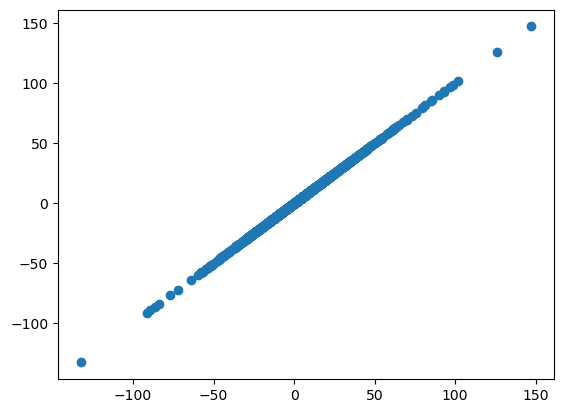

In [149]:
plt.scatter(out_mat.detach().cpu().numpy().flatten(), torch.sum(out_unf,dim=2).detach().cpu().numpy().flatten())

In [128]:
import tools.alignmentAnalysisTools as aat
hMax, wMax = aat.getMaximumStrides(inp.shape[2], inp.shape[3], net.conv1)
print(hMax, wMax)
        

14 14


In [129]:
14*14

196

In [100]:
activations = net.getActivations(images) # similarity.append(aat.similarityLinearLayer(activations[2], self.o))
print(activations[2].shape, net.o.weight.data.shape)

torch.Size([100, 256]) torch.Size([10, 256])


In [102]:
inpUnfolded = torch.nn.functional.unfold(inp, net.conv1.kernel_size, stride=net.conv1.stride, padding=net.conv1.padding, dilation=net.conv1.dilation).view(inp.size(0), -1)
inpUnfolded.shape

torch.Size([100, 1764])

In [110]:
w.view(w.size(0),-1).unsqueeze(2).expand(-1,-1,196).reshape(32,-1).shape

torch.Size([32, 1764])

In [113]:
wUnfolded = w.view(w.size(0),-1).repeat(1,196)
print(wUnfolded.shape)

torch.Size([32, 1764])


In [114]:
print(wUnfolded[0,0:9])
print(wUnfolded[0,9:18])

tensor([-0.1631, -0.2600,  0.1819, -0.1836, -0.2255,  0.2486, -0.0999,  0.1115,
         0.0878], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.1631, -0.2600,  0.1819, -0.1836, -0.2255,  0.2486, -0.0999,  0.1115,
         0.0878], device='cuda:0', grad_fn=<SliceBackward0>)


In [121]:
net.o.weight.shape

torch.Size([10, 256])